In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

## Funções Auxiliares

In [4]:
def remove_periodic(X, df_index, detrending=True, frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    
    return rad - rad_clean_ts.values, rad_clean_ts.values

In [105]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100


In [5]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="Tm",parse_dates=['Tm'], header=0, sep="\t")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    return frame

In [90]:
def splt_train_test(df, train_percent):

    from random import shuffle

    ind = pd.DataFrame({"dayofyear": df.index.dayofyear, "year": df.index.year})
    ind = ind.groupby(['dayofyear','year'], as_index=False).first()

    length = len(ind)
    train_size = int(train_percent * length)
    test_size = int((1 - train_percent) * length)

    indexes = np.arange(0,length)
    shuffle(indexes)

    train_ind = indexes[0:train_size]
    test_ind = indexes[train_size:]


    train_df = pd.DataFrame(columns=df.columns)
    test_df = pd.DataFrame(columns=df.columns)

    for i in train_ind:
        d = df[(df.index.dayofyear == ind.iloc[i].dayofyear) & (df.index.year == ind.iloc[i].year)]
        train_df = train_df.append(d)
    
    for i in test_ind:
        d = df[(df.index.dayofyear == ind.iloc[i].dayofyear) & (df.index.year == ind.iloc[i].year)]
        test_df = test_df.append(d)
        
    return train_df, test_df

In [59]:
shuffle(indexes)
indexes

array([101,   4,  87,  34,   3,  82,   8,  51,  58,  66,  61,  13,  91,
        48,  23,  40,  11,  95,  17,  74,  52,  28,  90,  42,  35, 115,
        70,  20,  26,  76,   6,  59,  43,  33,  15,  68,  22,  21,  31,
        32,  19,  75,  60,  65,  41,  67,   0,  71,  78,   5,  79,  50,
       102, 108, 119,  10, 100, 112,  97,  85,  37, 107,  77,  81,  12,
        56,  94,  83, 110,  30, 111, 113,  39,  16,  98,  46,  55,   9,
        14,  45,  44, 118,  64,  27,  93,  69, 103, 109, 116, 117,  63,
         1,  80,  88, 104,   7,  18,  38,  73,  57,  24,  96,  25, 114,
        49, 106,  47, 105,  54,  29,  92,  62,   2,  86,  99,  53,  72,
        89,  36,  84])

In [51]:
train_ind = indexes[0:train_size-1]
test_ind = indexes[train_size:]


df = s716_df
train_df = pd.DataFrame(columns=df.columns)

for i in train_ind:
    d = df[(df1.index.dayofyear == ind[i].dayofyear) & (df1.index.year == ind[i].year)]
    train_df.append(d)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

## Base SINGA

In [9]:
#Mac
singa_path = '/Users/cseveriano/spatio-temporal-forecasting/data/raw/SINGA-Nobre/'

#Windows
#singa_path = 'C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting\\data\\raw\\SINGA-Nobre\\'

s716_df = load_data(singa_path+"716", '15min')
s716_df = s716_df.fillna(method='ffill')

s717_df = load_data(singa_path+"717", '15min')
s717_df = s717_df.fillna(method='ffill')

In [10]:
s716_df = s716_df[(s716_df.index.hour >= 7) & (s716_df.index.hour <= 18)]
s717_df = s717_df[(s717_df.index.hour >= 7) & (s717_df.index.hour <= 18)]


In [11]:
s716_residual, s716_clean = remove_periodic(s716_df['AvgGsi00'],s716_df.index, frequency_threshold=0.01e11)
s717_residual, s717_clean = remove_periodic(s717_df['AvgGsi00'],s717_df.index, frequency_threshold=0.01e11)

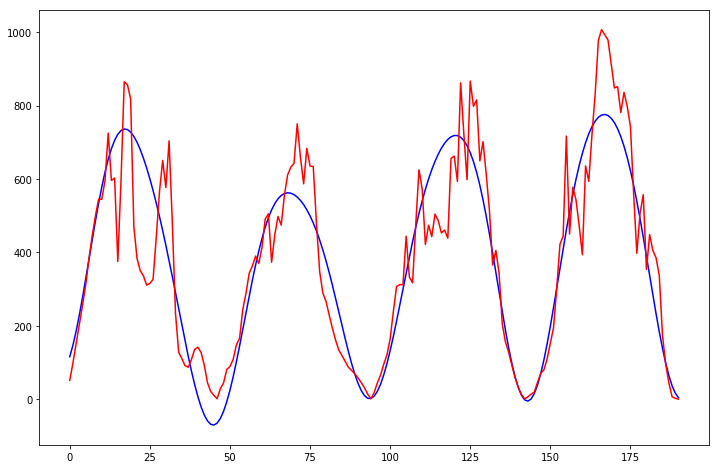

In [12]:
fig = plt.figure(figsize=(12, 8))
plt.plot(s716_clean[1:192], color='blue')
plt.plot(s716_df[1:192].AvgGsi00.tolist(), color='red')
plt.show()

In [13]:
s716_df = pd.DataFrame(data={'AvgGsi00': s716_df.AvgGsi00.tolist(), 'residual': s716_residual, 'clean': s716_clean, 'date' : s716_df.index}, index=s716_df.index)
s717_df = pd.DataFrame(data={'AvgGsi00': s717_df.AvgGsi00.tolist(), 'residual': s717_residual, 'clean': s717_clean, 'date' : s717_df.index}, index=s717_df.index)

In [95]:
s716_train_df, s716_test_df = splt_train_test(s716_df, 0.8)
s717_train_df, s717_test_df = splt_train_test(s717_df, 0.8)

## Vector Autoregressive (VAR)

In [98]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [96]:
train_var_df = pd.DataFrame(data={'s716_res': s716_train_df.residual.tolist(), 's717_res': s717_train_df.residual.tolist()}, index=s716_train_df.index)
test_var_df = pd.DataFrame(data={'s716_res': s716_test_df.residual.tolist(), 's717_res': s717_test_df.residual.tolist()}, index=s716_test_df.index)

In [99]:
model = VAR(train_var_df)
results = model.fit(maxlags=6, ic='aic')

In [104]:
order = results.k_ar
forecast = []
for i in range(len(test_df)-order) :
    forecast.append(results.forecast(test_var_df.values[i:i+order],1))

In [107]:
fcst = [item[0][0] for item in forecast]
obs = s716_test_df[order:].AvgGsi00.tolist()
fcst =  [sum(x) for x in zip(fcst, s716_test_df[order:].clean.tolist())]

In [108]:
_nrmse = normalized_rmse(obs, fcst)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  42.3370969704 



## High Order FTS

In [110]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models import hofts

In [111]:

train = s716_train_df.residual

fuzzy_sets = Grid.GridPartitioner(data=train, npart=100)
model_hofts = hofts.HighOrderFTS("FTS", partitioner=fuzzy_sets)
model_hofts.fit(train, order=6)

[ 17:43:39] Start training
[ 17:43:39] Starting batch 1
[ 17:43:47] Finish batch 1
[ 17:43:47] Starting batch 2
[ 17:43:57] Finish batch 2
[ 17:43:57] Starting batch 3
[ 17:44:06] Finish batch 3
[ 17:44:06] Starting batch 4
[ 17:44:15] Finish batch 4
[ 17:44:15] Starting batch 5
[ 17:44:23] Finish batch 5
[ 17:44:23] Starting batch 6
[ 17:44:32] Finish batch 6
[ 17:44:32] Starting batch 7
[ 17:44:41] Finish batch 7
[ 17:44:41] Starting batch 8
[ 17:44:50] Finish batch 8
[ 17:44:50] Starting batch 9
[ 17:44:58] Finish batch 9
[ 17:44:58] Starting batch 10
[ 17:45:07] Finish batch 10
[ 17:45:07] Starting batch 11
[ 17:45:07] Finish batch 11
[ 17:45:07] Finish training


In [112]:
forecast_hofts = model_hofts.predict(s716_test_df.residual)
forecasted_final = forecast_hofts + s716_test_df[5:].clean

In [113]:
_nrmse = normalized_rmse(s716_test_df.AvgGsi00.tolist()[5:], forecasted_final)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  7.45985492393 



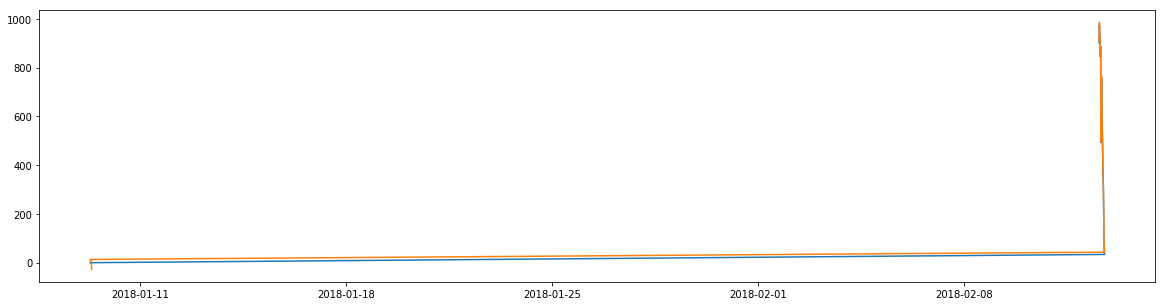

In [124]:
fig, ax = plt.subplots(figsize=[20,5])

test = s716_test_df[125:150]
fcst = forecasted_final[120:145]
ax.plot(test['date'].values, test['AvgGsi00'].values)
ax.plot(test['date'].values, fcst)

In [121]:
forecasted_final[95:145]

2018-02-12 08:00:00    115.202821
2018-02-12 08:15:00    154.738258
2018-02-12 08:30:00    195.553837
2018-02-12 08:45:00    202.888582
2018-02-12 09:00:00    295.961421
2018-02-12 09:15:00    419.481040
2018-02-12 09:30:00    404.069516
2018-02-12 09:45:00    442.416028
2018-02-12 10:00:00    559.642816
2018-02-12 10:15:00    633.496294
2018-02-12 10:30:00    689.443526
2018-02-12 10:45:00    706.271736
2018-02-12 11:00:00    770.344068
2018-02-12 11:15:00    726.943109
2018-02-12 11:30:00    864.203690
2018-02-12 11:45:00    887.188691
2018-02-12 12:00:00    903.523193
2018-02-12 12:15:00    967.386572
2018-02-12 12:30:00    771.010542
2018-02-12 12:45:00    851.558543
2018-02-12 13:00:00    941.568659
2018-02-12 13:15:00    679.648853
2018-02-12 13:30:00    924.653559
2018-02-12 13:45:00    939.439253
2018-02-12 14:00:00    925.424407
2018-02-12 14:15:00    909.510787
2018-02-12 14:30:00    985.482507
2018-02-12 14:45:00    951.949161
2018-02-12 15:00:00    915.859274
2018-02-12 15: